### 

#### Load embeddings from notebooks/FVC2006DB2_A_embeddings

In [73]:
# imports
from pathlib import Path as p
import numpy as np
import json

In [74]:
class Imp:
    def __init__(self, fp_id,im_id,emb):
        self.fp_id = fp_id
        self.im_id = im_id
        self.emb = emb
        self.walsh_emb = None
        self.perm_walsh_emb = None
        self.seg_perm_walsh_emb = None
        self.bin_seg_perm_walsh_emb = None

    def get_walsh_emb(self,k=256,r=5):
        if self.walsh_emb is None:
            self.walsh_emb = self._walsh_transform(self.emb,k,r)
        return self.walsh_emb
    
    def _walsh_transform(self,emb,k,r):
        from scipy.linalg import hadamard
        def generate_walsh_matrix(n):
            # Generate Hadamard matrix of order n
            H = hadamard(n)
            
            # Compute the Walsh ordering (sequency order)
            indices = sorted(range(n), key=lambda x: bin(x).count("1"))
            W = H[indices, :]
            
            return W
        def select_random_columns(walsh_matrix, k):
            """Select k random column vectors from the given walsh_matrix."""
            n = walsh_matrix.shape[1]
            selected_indices = np.random.choice(n, k, replace=False)
            return walsh_matrix[:, selected_indices]
        def select_columns_multiple_times(walsh_matrix, k, r):
            """Select k random column vectors r times from the given walsh_matrix."""
            selected_sets = []
            for _ in range(r):
                selected_columns = select_random_columns(walsh_matrix, k)
                selected_sets.append(selected_columns)
            return selected_sets
        
        transformed_vectors = []
        selected_columns = select_columns_multiple_times(generate_walsh_matrix(emb.shape[0]), k, r)
        for j in range(r):  # Use pre-selected columns
            transformed_vector = np.dot(emb.reshape(1, -1), selected_columns[j]).squeeze()  # Ensure (128,) instead of (1,128)
            transformed_vectors.append(transformed_vector)
        partial_walsh = np.array(transformed_vectors)
        # feature_dim = r * k  # 1280
        walsh = partial_walsh.flatten() # (r, k) -> (1280,)
        return walsh
    
    def get_perm_walsh_emb(self):
        if self.perm_walsh_emb is None:
            self.perm_walsh_emb = self._permute_emb(self.get_walsh_emb())
        return self.perm_walsh_emb

    def _permute_emb(self,emb):
        pemutations = np.random.permutation(emb.shape[0])
        permuted_vector = np.array([emb[i] for i in pemutations])
        return permuted_vector
    
    def _binary(self,emb):
        return (emb > 0).astype(int)

    def get_seg_perm_walsh_emb(self):
        if self.seg_perm_walsh_emb is None:
            self.seg_perm_walsh_emb = self._segment(self.get_perm_walsh_emb())
        return self.seg_perm_walsh_emb

    def _segment(self,emb, parts = 4):
        # seg_emb = []
        # segment_size = emb.shape[0] // parts  # 640 / 5 = 128
        segments = np.split(emb, parts)  # Split into 5 parts
        summed_vector = sum(segments)  # Element-wise sum across segments
        return summed_vector
        
    def get_bin_seg_perm_walsh_emb(self):
        if self.bin_seg_perm_walsh_emb is None:
            self.bin_seg_perm_walsh_emb = self._binary(self.get_seg_perm_walsh_emb())
        return self.bin_seg_perm_walsh_emb

def load_ids(jsn):
    subjects = jsn["array_subject"]
    samples = jsn["array_impression"]
    return zip(subjects, samples)

def load_imp_arr_from_emb_ids(e_fpath):
   
    e_npy_path = e_fpath/"embeddings.npy"
    ids_json_path =  e_fpath/"ids.json"

    emb_nparr = np.load(e_npy_path)
    ids = load_ids(json.load(ids_json_path.open('r')))
    
    return [Imp(fp_id,im_id,emb) for (fp_id,im_id), emb in zip(ids, emb_nparr)]




e_fpath = p("/home/mt0/22CS60R42/fixed-length-fingerprint-extractors/notebooks/FVC2006DB2_A_embeddings")
imp_arr = load_imp_arr_from_emb_ids(e_fpath)

In [75]:
num_persons = 140
num_imp = 12

# we=fp_arr[0].get_walsh_transform_emb()
for imp in imp_arr:
    bspwe = imp.get_bin_seg_perm_walsh_emb()
    print(bspwe)
    break

[1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 1
 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1
 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1
 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1
 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0
 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1
 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0
 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1]


In [76]:
def hamming_distance(key1, key2):
    """Compute Hamming distance between two binary keys."""
    return np.sum(key1 != key2)

binary_key_array = np.array([fp.get_bin_seg_perm_walsh_emb() for fp in imp_arr])
num_keys = binary_key_array.shape[0]
hamming_distances = np.zeros((num_keys, num_keys))

for i in range(num_keys):
    for j in range(num_keys):
        if i != j:
            hamming_distances[i, j] = hamming_distance(binary_key_array[i], binary_key_array[j])

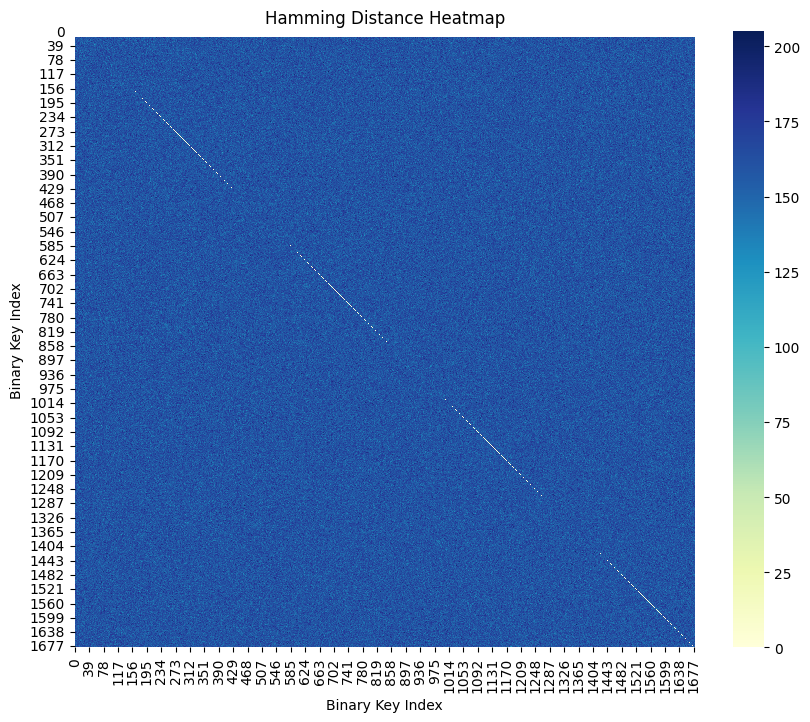

In [77]:
# Visualization of Hamming Distances
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(hamming_distances, annot=True, fmt=".0f", cmap="YlGnBu", cbar=True)
plt.title('Hamming Distance Heatmap')
plt.xlabel('Binary Key Index')
plt.ylabel('Binary Key Index')
plt.show()